In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



%cd /content/drive/MyDrive/COMP576/

!nvidia-smi

Mounted at /content/drive
/content/drive/MyDrive/COMP576
Wed Nov  2 22:33:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                               

In [6]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Loaded 500 train images from class 0.
Loaded 100 test images from class 0.
Loaded 500 train images from class 1.
Loaded 100 test images from class 1.
Loaded 500 train images from class 2.
Loaded 100 test images from class 2.
Loaded 500 train images from class 3.
Loaded 100 test images from class 3.
Loaded 500 train images from class 4.
Loaded 100 test images from class 4.
Loaded 500 train images from class 5.
Loaded 100 test images from class 5.
Loaded 500 train images from class 6.
Loaded 100 test images from class 6.
Loaded 500 train images from class 7.
Loaded 100 test images from class 7.
Loaded 500 train images from class 8.
Loaded 100 test images from class 8.
Loaded 500 train images from class 9.
Loaded 100 test images from class 9.
Step #0. Train Loss: 10.000940322875977; Train Acc: 0.10000000149011612; Test Acc: 0.09700000286102295
Step #100. Train Loss: 1.9369598627090454; Train Acc: 0.3199999928474426; Test Acc: 0.3059999942779541
Step #200. Train Loss: 1.8821743726730347; T

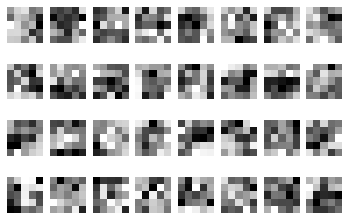

h_conv1_stats: mean = 0.08629325032234192; var = 0.012447437271475792
h_conv2_stats: mean = 0.015239840373396873; var = 0.009520959109067917


In [95]:
#Henry Zhong
from scipy import misc
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random
import matplotlib.pyplot as plt
import matplotlib as mp

from imageio import imread
from PIL import Image

# --------------------------------------------------
# setup

def weight_variable(shape):
    '''
    Initialize weights
    :param shape: shape of weights, e.g. [w, h ,Cin, Cout] where
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters
    Cout: the number of filters
    :return: a tensor variable for weights with initial values
    '''

    # IMPLEMENT YOUR WEIGHT_VARIABLE HERE
    W = tf.truncated_normal(shape, stddev = 0.1)
    W = tf.Variable(W)
    return W

def bias_variable(shape):
    '''
    Initialize biases
    :param shape: shape of biases, e.g. [Cout] where
    Cout: the number of filters
    :return: a tensor variable for biases with initial values
    '''

    # IMPLEMENT YOUR BIAS_VARIABLE HERE
    b = tf.constant(0.1, shape = shape)
    b = tf.Variable(b)
    return b

def conv2d(x, W):
    '''
    Perform 2-D convolution
    :param x: input tensor of size [N, W, H, Cin] where
    N: the number of images
    W: width of images
    H: height of images
    Cin: the number of channels of images
    :param W: weight tensor [w, h, Cin, Cout]
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters = the number of channels of images
    Cout: the number of filters
    :return: a tensor of features extracted by the filters, a.k.a. the results after convolution
    '''

    h_conv = tf.nn.conv2d(x, W, [1, 1, 1, 1], "SAME")
    return h_conv

def max_pool_2x2(x):
    '''
    Perform non-overlapping 2-D maxpooling on 2x2 regions in the input data
    :param x: input data
    :return: the results of maxpooling (max-marginalized + downsampling)
    '''

    # IMPLEMENT YOUR MAX_POOL_2X2 HERE
    h_max = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], "SAME")
    return h_max


ntrain = 500 # per class
ntest = 100 # per class
nclass = 10 # number of classes
imsize = 28
nchannels = 1
batchsize = 50

Train = np.zeros((ntrain*nclass,imsize,imsize,nchannels))
Test = np.zeros((ntest*nclass,imsize,imsize,nchannels))
LTrain = np.zeros((ntrain*nclass,nclass))
LTest = np.zeros((ntest*nclass,nclass))

itrain = -1
itest = -1
base_data_path = '/content/drive/MyDrive/CIFAR10/'
for iclass in range(0, nclass):
    for isample in range(0, ntrain):
        sub_data_path = 'Train/%d/Image%05d.png' % (iclass,isample)
        path = base_data_path + sub_data_path
        # im = imread(path); # 28 by 28
        im = np.asarray(Image.open(path), dtype = np.float64)
        # print(f'Image {path} done')
        im = im.astype(float)/255
        # if isample%10 == 0:
        #     print(f'\r{isample+1}/{ntrain} done.\r')
        itrain += 1
        Train[itrain,:,:,0] = im
        LTrain[itrain,iclass] = 1 # 1-hot lable
    print(f'Loaded {ntrain} train images from class {iclass}.')
    for isample in range(0, ntest):
        sub_data_path = 'Test/%d/Image%05d.png' % (iclass,isample)
        path = base_data_path + sub_data_path
        # im = imread(path); # 28 by 28
        im = np.asarray(Image.open(path), dtype = np.float64)
        im = im.astype(float)/255
        # if isample%10 == 0:
        #     print(f'\r{isample+1}/{ntest} done.\r')
        itest += 1
        Test[itest,:,:,0] = im
        LTest[itest,iclass] = 1 # 1-hot lable
    print(f'Loaded {ntest} test images from class {iclass}.')

sess = tf.InteractiveSession()

#tf variable for the data, remember shape is [None, width, height, numberOfChannels]
tf_data = tf.placeholder(tf.float32, [None, imsize, imsize, nchannels])
#tf variable for labels
tf_labels = tf.placeholder(tf.float32, [None, nclass])

# --------------------------------------------------
# model
#create your model

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(tf_data, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# --------------------------------------------------
# loss
#set up the loss, optimization, evaluation, and accuracy

cross_entropy = tf.reduce_mean(-tf.reduce_sum(tf_labels * tf.log(y_conv), reduction_indices=[1]))

learning_rate = tf.placeholder(tf.float32, shape=[])

optimizer = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate = 1e-2).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(tf_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# --------------------------------------------------
# optimization

sess.run(tf.initialize_all_variables())
batch_xs = np.zeros([batchsize, imsize, imsize, nchannels]) #setup as [batchsize, width, height, numberOfChannels] and use np.zeros()
batch_ys = np.zeros([batchsize, nclass]) #setup as [batchsize, the how many classes]

nsamples = ntrain * nclass

log_list = []
for i in range(2000): # try a small iteration size once it works then continue
    perm = np.arange(nsamples)
    np.random.shuffle(perm)

    it_feed_dict = {tf_data: batch_xs, tf_labels: batch_ys, keep_prob: 0.5}
    for j in range(batchsize):
        batch_xs[j,:,:,:] = Train[perm[j],:,:,:]
        batch_ys[j,:] = LTrain[perm[j],:]
    it_loss = cross_entropy.eval(feed_dict = it_feed_dict)
    it_acc = accuracy.eval(feed_dict = it_feed_dict)
    # record params
    # first_weight = W_conv1.eval()
    if i%100 == 0:
        #calculate train accuracy and print it
        it_test_acc = accuracy.eval(feed_dict={tf_data: Test, tf_labels: LTest, keep_prob: 1.0})
        print(f'Step #{i}. Train Loss: {it_loss}; Train Acc: {it_acc}; Test Acc: {it_test_acc}')
        log_list.append((i, it_loss, it_acc, it_test_acc))
    optimizer.run(feed_dict = it_feed_dict) # dropout only during training

# --------------------------------------------------
# test


print('#'*20)
print(log_list)
print("Final test accuracy %g"%accuracy.eval(feed_dict={tf_data: Test, tf_labels: LTest, keep_prob: 1.0}))

# --------------------------------------------------
# visualization

first_conv_weights = W_conv1.eval()


fig = plt.figure()
for i in range(32):
    ax = fig.add_subplot(4, 8, 1 + i)
    ax.imshow(first_conv_weights[:, :, 0, i], cmap='gray')
    plt.axis('off')
plt.savefig('1st conv layer')
plt.show()

# --------------------------------------------------
# activation stats

h_conv1_stats = np.array(h_conv1.eval(feed_dict = {tf_data: Test, tf_labels: LTest, keep_prob: 1.0}))
h_conv2_stats = np.array(h_conv2.eval(feed_dict = {tf_data: Test, tf_labels: LTest, keep_prob: 1.0}))
print(f'h_conv1_stats: mean = {np.mean(h_conv1_stats)}; var = {np.var(h_conv1_stats)}')
print(f'h_conv2_stats: mean = {np.mean(h_conv2_stats)}; var = {np.var(h_conv2_stats)}')


sess.close()

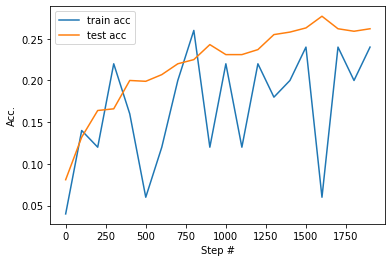

In [81]:
import matplotlib.pyplot as plt

input = [(0, 15.664182, 0.04, 0.081), (100, 3.420445, 0.14, 0.132), (200, 2.5499897, 0.12, 0.164), (300, 2.2371066, 0.22, 0.166), (400, 2.4379663, 0.16, 0.2), (500, 2.36761, 0.06, 0.199), (600, 2.2497404, 0.12, 0.207), (700, 2.2751899, 0.2, 0.22), (800, 2.3075957, 0.26, 0.225), (900, 2.1817377, 0.12, 0.243), (1000, 2.1247454, 0.22, 0.231), (1100, 2.1825147, 0.12, 0.231), (1200, 2.29993, 0.22, 0.237), (1300, 2.1764975, 0.18, 0.255), (1400, 2.2973058, 0.2, 0.258), (1500, 2.212947, 0.24, 0.263), (1600, 2.210685, 0.06, 0.277), (1700, 2.229136, 0.24, 0.262), (1800, 2.084505, 0.2, 0.259), (1900, 2.178103, 0.24, 0.262)]


x = [i[0] for i in input]
y_train_loss = [i[1] for i in input]
y_train_acc = [i[2] for i in input]
y_test_acc = [i[3] for i in input]

# plt.plot(x, y_train_loss, label="train loss")
plt.plot(x, y_train_acc, label="train acc")
plt.plot(x, y_test_acc, label="test acc")
plt.plot()

plt.xlabel("Step #")
plt.ylabel("Acc.")
plt.legend()
plt.show()


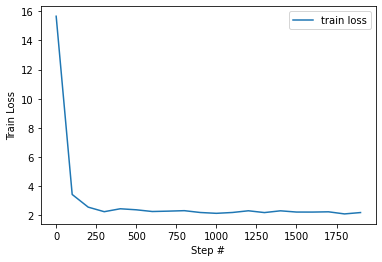

In [82]:
import matplotlib.pyplot as plt

input = [(0, 15.664182, 0.04, 0.081), (100, 3.420445, 0.14, 0.132), (200, 2.5499897, 0.12, 0.164), (300, 2.2371066, 0.22, 0.166), (400, 2.4379663, 0.16, 0.2), (500, 2.36761, 0.06, 0.199), (600, 2.2497404, 0.12, 0.207), (700, 2.2751899, 0.2, 0.22), (800, 2.3075957, 0.26, 0.225), (900, 2.1817377, 0.12, 0.243), (1000, 2.1247454, 0.22, 0.231), (1100, 2.1825147, 0.12, 0.231), (1200, 2.29993, 0.22, 0.237), (1300, 2.1764975, 0.18, 0.255), (1400, 2.2973058, 0.2, 0.258), (1500, 2.212947, 0.24, 0.263), (1600, 2.210685, 0.06, 0.277), (1700, 2.229136, 0.24, 0.262), (1800, 2.084505, 0.2, 0.259), (1900, 2.178103, 0.24, 0.262)]

x = [i[0] for i in input]
y_train_loss = [i[1] for i in input]
y_train_acc = [i[2] for i in input]
y_test_acc = [i[3] for i in input]

plt.plot(x, y_train_loss, label="train loss")
# plt.plot(x, y_train_acc, label="train acc")
# plt.plot(x, y_test_acc, label="test acc")
plt.plot()

plt.xlabel("Step #")
plt.ylabel("Train Loss")
plt.legend()
plt.show()


In [2]:
import assignment_2.input_data as input_data

In [47]:
#Henry Zhong
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()

# import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
# from tensorflow.python.ops import rnn_cell
import numpy as np

import assignment_2.input_data as input_data
# from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot = True)#call mnist function

learningRate = 1e-3
trainingIters = 50000
batchSize = 128
displayStep = 20

nInput =  28#we want the input to take the 28 pixels
nSteps =  28 #every 28
nHidden = 64 #number of neurons for the RNN
nClasses = 10 #this is MNIST so you know

x = tf.placeholder('float', [None, nSteps, nInput])
y = tf.placeholder('float', [None, nClasses])

weights = {
	'out': tf.Variable(tf.random_normal([nHidden, nClasses]))
}

biases = {
	'out': tf.Variable(tf.random_normal([nClasses]))
}

def RNN(x, weights, biases):
	x = tf.transpose(x, [1,0,2])
	x = tf.reshape(x, [-1, nInput])
	x = tf.split(x, nSteps, 0) #configuring so you can get it as needed for the 28 pixels

	# lstmCell = rnn.BasicRNNCell(nHidden) #find which lstm to use in the documentation
	# lstmCell = rnn_cell.BasicRNNCell(nHidden) #find which lstm to use in the documentation
	# lstmCell = rnn_cell.BasicLSTMCell(nHidden, forget_bias=1.0)
	lstmCell = rnn_cell.GRUCell(nHidden)

	outputs, states = rnn.static_rnn(lstmCell, x, dtype=tf.float32)#for the rnn where to get the output and hidden state

	return tf.matmul(outputs[-1], weights['out'])+ biases['out']

pred = RNN(x, weights, biases)

#optimization
#create the cost, optimization, evaluation, and accuracy
#for the cost softmax_cross_entropy_with_logits seems really good
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate = learningRate).minimize(cost)

correctPred = tf.equal(tf.argmax(pred, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

init = tf.initialize_all_variables()

log_list = []
testData = mnist.test.images.reshape((-1, nSteps, nInput))
testLabel = mnist.test.labels
test_feed_dict = {x: testData, y: testLabel}
with tf.Session() as sess:
	sess.run(init)
	step = 1

	while step* batchSize < trainingIters:
		batchX, batchY = mnist.train.next_batch(batchSize) #mnist has a way to get the next batch
		batchX = batchX.reshape((batchSize, nSteps, nInput))


		batch_feed_dict = {x: batchX, y: batchY}
		sess.run(optimizer, feed_dict = batch_feed_dict)
		train_acc = sess.run(accuracy, feed_dict = batch_feed_dict)
		loss = sess.run(cost, feed_dict = batch_feed_dict)
		test_acc = sess.run(accuracy, feed_dict = test_feed_dict)
		if step % displayStep == 0:
			log_list.append([step * batchSize, loss, train_acc, test_acc])
			print("Iter " + str(step*batchSize) + ", Minibatch Loss = " + \
					  "{:.6f}".format(loss) + ", Training Accuracy = " + \
					  "{:.5f}".format(train_acc))
			print(f'Test acc: {test_acc}')


		step +=1

	print('Optimization finished')

	# testData = mnist.test.images.reshape((-1, nSteps, nInput))
	# testLabel = mnist.test.labels
	test_feed_dict = {x: testData, y: testLabel}
	print("Final Test Accuracy:", \
		sess.run(accuracy, feed_dict = test_feed_dict))

print(log_list)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iter 2560, Minibatch Loss = 2.138169, Training Accuracy = 0.25000
Test acc: 0.3050999939441681
Iter 5120, Minibatch Loss = 1.853819, Training Accuracy = 0.35156
Test acc: 0.413100004196167
Iter 7680, Minibatch Loss = 1.297559, Training Accuracy = 0.59375
Test acc: 0.5198000073432922
Iter 10240, Minibatch Loss = 1.200397, Training Accuracy = 0.61719
Test acc: 0.6159999966621399
Iter 12800, Minibatch Loss = 0.976686, Training Accuracy = 0.65625
Test acc: 0.7027000188827515
Iter 15360, Minibatch Loss = 0.650585, Training Accuracy = 0.79688
Test acc: 0.73089998960495
Iter 17920, Minibatch Loss = 0.615305, Training Accuracy = 0.78125
Test acc: 0.77920001745224
Iter 20480, Minibatch Loss = 0.503971, Training Accuracy = 0.82031
Test acc: 0.805899977684021
Iter 23040, Minibatch Loss = 0.428301, Training

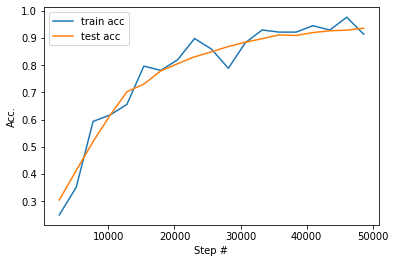

In [48]:
import matplotlib.pyplot as plt

input = [[2560, 2.1381688, 0.25, 0.3051], [5120, 1.853819, 0.3515625, 0.4131], [7680, 1.2975587, 0.59375, 0.5198], [10240, 1.2003965, 0.6171875, 0.616], [12800, 0.9766856, 0.65625, 0.7027], [15360, 0.6505847, 0.796875, 0.7309], [17920, 0.61530465, 0.78125, 0.7792], [20480, 0.50397074, 0.8203125, 0.8059], [23040, 0.4283014, 0.8984375, 0.831], [25600, 0.40028802, 0.859375, 0.8497], [28160, 0.5865559, 0.7890625, 0.869], [30720, 0.30810308, 0.8828125, 0.8847], [33280, 0.3402683, 0.9296875, 0.8978], [35840, 0.27648813, 0.921875, 0.9116], [38400, 0.24264152, 0.921875, 0.9097], [40960, 0.2054255, 0.9453125, 0.9202], [43520, 0.28510946, 0.9296875, 0.9267], [46080, 0.14897436, 0.9765625, 0.9292], [48640, 0.32432073, 0.9140625, 0.9363]]







x = [i[0] for i in input]
# y_train_loss = [i[1] for i in input]
y_train_acc = [i[2] for i in input]
y_test_acc = [i[3] for i in input]

# plt.plot(x, y_train_loss, label="train loss")
plt.plot(x, y_train_acc, label="train acc")
plt.plot(x, y_test_acc, label="test acc")
plt.plot()

plt.xlabel("Step #")
plt.ylabel("Acc.")
plt.legend()
plt.show()


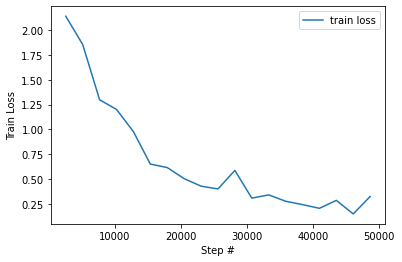

In [49]:
import matplotlib.pyplot as plt

input = [[2560, 2.1381688, 0.25, 0.3051], [5120, 1.853819, 0.3515625, 0.4131], [7680, 1.2975587, 0.59375, 0.5198], [10240, 1.2003965, 0.6171875, 0.616], [12800, 0.9766856, 0.65625, 0.7027], [15360, 0.6505847, 0.796875, 0.7309], [17920, 0.61530465, 0.78125, 0.7792], [20480, 0.50397074, 0.8203125, 0.8059], [23040, 0.4283014, 0.8984375, 0.831], [25600, 0.40028802, 0.859375, 0.8497], [28160, 0.5865559, 0.7890625, 0.869], [30720, 0.30810308, 0.8828125, 0.8847], [33280, 0.3402683, 0.9296875, 0.8978], [35840, 0.27648813, 0.921875, 0.9116], [38400, 0.24264152, 0.921875, 0.9097], [40960, 0.2054255, 0.9453125, 0.9202], [43520, 0.28510946, 0.9296875, 0.9267], [46080, 0.14897436, 0.9765625, 0.9292], [48640, 0.32432073, 0.9140625, 0.9363]]









x = [i[0] for i in input]
y_train_loss = [i[1] for i in input]
# y_train_acc = [i[2] for i in input]
# y_test_acc = [i[3] for i in input]

plt.plot(x, y_train_loss, label="train loss")
# plt.plot(x, y_train_acc, label="train acc")
# plt.plot(x, y_test_acc, label="test acc")
plt.plot()

plt.xlabel("Step #")
plt.ylabel("Train Loss")
plt.legend()
plt.show()
